In [ ]:
# Check cuda version
!cat /usr/local/cuda/version.txt

# Install pytorch and torchvision with cuda
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.ion()   # interactive mode

torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Assign device to GPU if present, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/ML')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Transforms to resize and convert to tensor
data_transforms = {
    'train': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()]),
    'test': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()]),
}

In [4]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes
print(class_names)

['with_mask', 'without_mask']


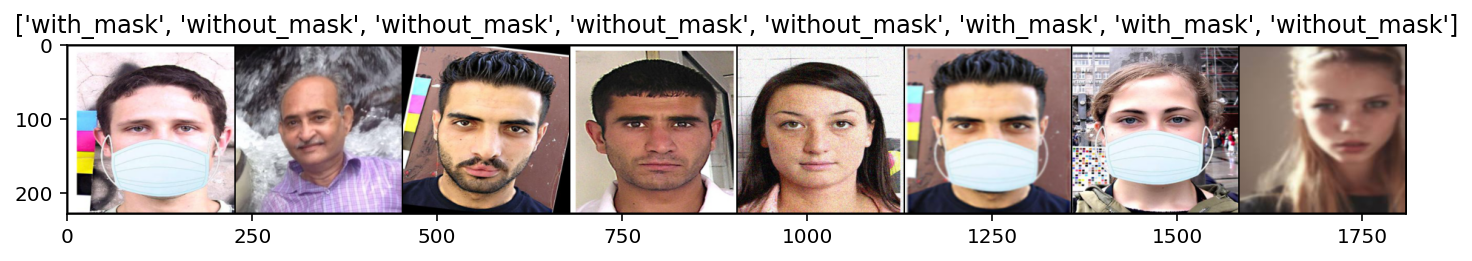

In [5]:
plt.figure(figsize=(12,8))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # To store best model weights and accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # inputs.size(0) contains the batch size
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            # calculate loss and accuracy of current epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:
model_ft = models.resnet50(pretrained=True)

# total features in last layer of resnet50
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4329 Acc: 0.8676
test Loss: 0.1882 Acc: 0.9964

Epoch 1/9
----------
train Loss: 0.1943 Acc: 0.9556
test Loss: 0.0930 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.1099 Acc: 0.9813
test Loss: 0.0492 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0895 Acc: 0.9831
test Loss: 0.0332 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0916 Acc: 0.9742
test Loss: 0.0272 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0522 Acc: 0.9929
test Loss: 0.0163 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0435 Acc: 0.9938
test Loss: 0.0152 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0760 Acc: 0.9840
test Loss: 0.0124 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0559 Acc: 0.9858
test Loss: 0.0114 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0421 Acc: 0.9884
test Loss: 0.0256 Acc: 1.0000

Training complete in 7m 41s
Best val Acc: 1.000000


In [10]:
# Save model to disk for future use
torch.save(model_ft,'face_mask_model.pth')